In [1]:
import logging
from copy import copy
from enum import Enum

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

from IPython.display import clear_output
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, AngleAxis,
                         Concatenate, DiagramBuilder, InputPortIndex,
                         LeafSystem, MeshcatVisualizer, ContactVisualizerParams, ContactVisualizer, MeshcatVisualizerParams, Parser,
                         PiecewisePolynomial, PiecewisePose, PointCloud, RandomGenerator, RigidTransform,
                         RollPitchYaw, Simulator, StartMeshcat,
                         UniformlyRandomRotationMatrix,
                         BsplineTrajectory, Sphere, Rgba,
                         KinematicTrajectoryOptimization, Solve, MinimumDistanceConstraint,
                         PositionConstraint, ModelInstanceIndex,
                         SpatialVelocity, LinearConstraint, BoundingBoxConstraint, LogVectorOutput,
                         IpoptSolver,SnoptSolver)

from manipulation import FindResource, running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import (AddPackagePaths,
                                    MakeManipulationStation, AddIiwa, AddShape, AddWsg, AddMultibodyTriad)

import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox
from io import StringIO
import sys

from utils import *
from diff_ik_adjuster import *

In [2]:
# Start the visualizer.
helper_meshcat = StartMeshcat()
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://68a898be-bd4e-4046-916a-6293aadf6c5d.deepnoteproject.com/7007/


INFO:drake:Meshcat listening for connections at https://68a898be-bd4e-4046-916a-6293aadf6c5d.deepnoteproject.com/7008/


# Configuration

In [3]:
num_balls = 1 # How many balls to juggle
# Manipulation Station Parameters
time_step= 0.0001 if num_balls < 4 else 0.00005
# use_direct determines whether to feed the desired q, v, a into InverseDynamicsController
# or to use the default position based iiwa controller
use_direct = True
update_traj_after_catch = False
warm_start_velocities = True
max_height = 0.6 # Max height ball will reach in meters
use_small_ball = False
# Kin Traj Opt Parameters
num_control_points = 11

display_plot = True
add_text_to_pdf = False
should_print_contact_results = False

if use_small_ball:
    ball_radius = 0.008
else:
    ball_radius = 0.02

p_GB_G = [0, 0.11, 0]

q_Throw = np.array([-0.54, 0.58, 0, -1.79, 0, -0.79, 0])
p_WThrow = [0.57, -0.34, 0.39]
R_WThrow = RollPitchYaw([-np.pi, 0.00, 1.03])

q_Catch = np.array([-0.74, 0.58, 0, -1.79, 0, -0.79, 0])
p_WCatch = [0.49, -0.45, 0.39]
R_WCatch = RollPitchYaw([-np.pi, 0.00, 0.83])

X_WThrow = RigidTransform(R_WThrow, p_WThrow)
X_WCatch = RigidTransform(R_WCatch, p_WCatch)

X_WThrowB_W, X_WCatchB_W = get_ball_poses_from_gripper_poses(X_WThrow, X_WCatch, p_GB_G)

V_ThrowB, V_CatchB, air_duration = calculate_ball_vels(X_WThrowB_W.translation(), X_WCatchB_W.translation(), max_height)

# Time related variables
t_duration = round((air_duration/(num_balls*2-1)),3)
sim_duration = (5/num_balls) * air_duration

v_Throw = convert_spatial_vel_ball_to_joint_vel_arm(q_Throw, V_ThrowB, p_GB_G)
v_Catch = convert_spatial_vel_ball_to_joint_vel_arm(q_Catch, V_CatchB, p_GB_G)

# WSG gripper
should_release_ball = True
if use_small_ball:
    wsg_buff_open = 0.001
    wsg_buff_close = 0.09
    closed = np.array([0.001])
    opened = np.array([0.090])
else:
    wsg_buff_open = 0.001
    wsg_buff_close = 0.07
    closed = np.array([0.025])
    opened = np.array([0.090])
if not should_release_ball:
    opened = closed

internal_model = make_internal_model()

The order of operations:
1. We start with comfortable joint angles for the iiwa q_throw and q_catch.
1. We use forward kinematics to get spatial positions p_WThrow and p_WCatch
1. we translate those by the offset between the ball and the gripper p_GB_G, to get the spatial positions the ball will be in at the point of being thrown (release) and caught X_WThrowB_W, X_WCatchB_W
1. we calculate using simple physics the spatial velocity of the ball at the point of being thrown and caught V_WThrowB_W, V_WCatchB_W, as well as the joint angle for the last iiwa link (rotation of the gripper such that it will parallel to the velocity of the ball), given a particular max height h that it reaches.
1. we use the Jacobian to transform the spatial velocities of the ball into joint velocities of the iiwa v_Throw and v_Catch, taking into account the offset between the gripper and the ball.
1. We feed the joint positions and velocities into kin traj opt so they can be used as constraints to optimize the trajectory.


In [4]:
# Joint position and velocity constraints
def make_kin_traj_opt_trajectory(q0, q1, v0, v1, t_duration):
    context = internal_model.CreateDefaultContext()
    plant = internal_model.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)

    num_positions = 7
    s = [0.0, 0.5, 1.0] # Key scaled time values
    trajopt = KinematicTrajectoryOptimization(num_positions, num_control_points)
    prog = trajopt.get_mutable_prog()

    control_points_per_segment = int(trajopt.num_control_points()/(len(s)-1))
    q_guess = np.tile(q0.reshape((num_positions,1)), (1, trajopt.num_control_points()))
    # q_guess[0,:] = np.linspace(q0[0], q1[0], trajopt.num_control_points())
    q_guess[0,:control_points_per_segment] = np.linspace(q0[0], q1[0], control_points_per_segment)
    q_guess[0,control_points_per_segment+1:] = np.linspace(q1[0], q0[0], control_points_per_segment)
    # q_guess[0,2*control_points_per_segment:] = np.linspace(q0[0], q1[0], control_points_per_segment)
    path_guess = BsplineTrajectory(trajopt.basis(), q_guess)
    trajopt.SetInitialGuess(path_guess)
    
    trajopt.AddPathLengthCost(1)
    prog.AddQuadraticErrorCost(np.eye(7), q0,
                               trajopt.control_points()[:, 0])
    
    # prog.AddQuadraticErrorCost(np.eye(7), q0,
    #                            trajopt.control_points()[:, 1])
    
    prog.AddQuadraticErrorCost(np.eye(7), q1,
                               trajopt.control_points()[:, np.round(num_control_points/2).astype(int)-3])
    # Extra one to shift the gripper closer to q1 to avoid collision
    prog.AddQuadraticErrorCost(np.eye(7), q1,
                               trajopt.control_points()[:, np.round(num_control_points/2).astype(int)])

    prog.AddQuadraticErrorCost(np.eye(7), q0,
                               trajopt.control_points()[:, -1])

    trajopt.AddPositionBounds(plant.GetPositionLowerLimits()[:num_positions],
                              plant.GetPositionUpperLimits()[:num_positions])
    trajopt.AddVelocityBounds(plant.GetVelocityLowerLimits()[:num_positions],
                              plant.GetVelocityUpperLimits()[:num_positions])
    # trajopt.AddVelocityBounds([-10] * 7, [10] * 7) # Super high velocity limits

    trajopt.AddDurationConstraint(2 * t_duration, 2 * t_duration)

    eps = 0.0001
    lb0, ub0 = offset_vec_by_eps(q0, eps)
    lb1, ub1 = offset_vec_by_eps(q1, eps)

    # constrain positions in joint angles
    trajopt.AddPathPositionConstraint(lb0, ub0, s[0])
    trajopt.AddPathPositionConstraint(lb1, ub1, s[1])
    trajopt.AddPathPositionConstraint(lb0, ub0, s[2])
    # trajopt.AddPathPositionConstraint(lb1, ub1, s[3])
    
    q_q_dot1 = np.concatenate((q1.reshape(num_positions,1), v1.reshape(num_positions,1)), axis = 0)
    q_q_dot0 = np.concatenate((q0.reshape(num_positions,1), v0.reshape(num_positions,1)), axis = 0)

    eps = 0.0001
    lb0, ub0 = offset_vec_by_eps(q_q_dot0, eps)
    lb1, ub1 = offset_vec_by_eps(q_q_dot1, eps)

    q_dot_bbox_constraint0 = BoundingBoxConstraint(lb0, ub0)
    q_dot_bbox_constraint1 = BoundingBoxConstraint(lb1, ub1)
    
    # constrain velocities in joint angles
    trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint0, s[0])
    trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint1, s[1])
    trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint0, s[2])
    # trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint1, s[3])

    solver = SnoptSolver()
    result = solver.Solve(prog)
    if not result.is_success():
        print("Trajectory optimization failed, even without collisions!")
        print(result.get_solver_id().name())
    else:
        print("Trajectory optimization succeeded! (without collisions)")
    
    # # collision constraints
    # collision_constraint = MinimumDistanceConstraint(plant, 0.001,
    #                                                  plant_context, None, 0.01)
    # evaluate_at_s = np.linspace(0, 1, 25)
    # for s in evaluate_at_s:
    #     trajopt.AddPathPositionConstraint(collision_constraint, s)

    # result = Solve(prog)
    # if not result.is_success():
    #     print("Trajectory optimization failed WITH collisions")
    #     print(result.get_solver_id().name())
    # else:
    #     print("Trajectory optimization succeeded! (WITH collisions)")

    pos_traj = trajopt.ReconstructTrajectory(result)
    vel_traj = pos_traj.MakeDerivative()
    acc_traj = vel_traj.MakeDerivative()

    return pos_traj, vel_traj, acc_traj

In [5]:
class Planner(LeafSystem):
    def __init__(self, plant, ball_body_indices):
        LeafSystem.__init__(self)
        self._ball_body_indices = ball_body_indices
        self._diff_ik_adjuster = DiffIKAdjuster(helper_meshcat)

        # Input ports
        self._body_poses_index = self.DeclareAbstractInputPort("body_poses",
            AbstractValue.Make([RigidTransform()])).get_index()
        self._body_spatial_velocities_index = self.DeclareAbstractInputPort("body_spatial_velocities",
                                                    AbstractValue.Make([SpatialVelocity()])).get_index()
        self._wsg_state_index = self.DeclareVectorInputPort("wsg_state",
                                                    2).get_index()
        num_positions = 7
        self._iiwa_state_estimated_index = self.DeclareVectorInputPort("iiwa_state_estimated",
                                                    2 * num_positions).get_index()

        # State
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial()))
        self._traj_start_time_index = self.DeclareAbstractState(
            AbstractValue.Make(0.0)
        )
        self._ball_to_catch_index = self.DeclareAbstractState(
            AbstractValue.Make(0 if num_balls==1 else 1)
        )
        self._traj_arm_q_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )
        self._traj_arm_v_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )
        self._traj_arm_a_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )

        # Output ports
        self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)
        self.DeclareVectorOutputPort("traj_start_time", 1, self.GetTrajStartTime)
        self.DeclareVectorOutputPort("iiwa_state_desired", 2 * num_positions,
                                     self.CalcIiwaDesiredState)
        self.DeclareVectorOutputPort("iiwa_acceleration_desired", num_positions,
                                     self.CalcIiwaDesiredAcceleration)
        self.DeclareVectorOutputPort("iiwa_position_command", num_positions,
                                     self.CalcIiwaPosition)
        
        self.DeclareInitializationUnrestrictedUpdateEvent(self.InitializeTrajectory)
        self.DeclarePeriodicUnrestrictedUpdateEvent(2 * t_duration, t_duration, self.TrajPostThrowUpdate) # update after throw
        if update_traj_after_catch:
            self.DeclarePeriodicUnrestrictedUpdateEvent(2 * t_duration, 2 * t_duration, self.TrajPostCatchUpdate) # update after catch
    
    def InitializeTrajectory(self, context, state):
        # iiwa trajectory
        q_traj, v_traj, a_traj= make_kin_traj_opt_trajectory(
            q_Catch,
            q_Throw, 
            v_Catch,
            v_Throw, 
            t_duration)

        # Store them in states
        state.get_mutable_abstract_state(int(
            self._traj_start_time_index)).set_value(0.0)
        state.get_mutable_abstract_state(int(
            self._traj_arm_q_index)).set_value(q_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_v_index)).set_value(v_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_a_index)).set_value(a_traj)

        # WSG Gripper Trajectory
        throw_time = t_duration
        catch_time = t_duration*2
        
        times = [0, throw_time-wsg_buff_open, throw_time, catch_time-wsg_buff_close, catch_time]
        positions = np.hstack([[closed], [closed], [opened], [opened], [closed]])
        traj_wsg_command = PiecewisePolynomial.FirstOrderHold(times, positions)

        state.get_mutable_abstract_state(int(
            self._traj_wsg_index)).set_value(traj_wsg_command)
    
    def TrajPostThrowUpdate(self, context, state):
        current_time = context.get_time()
        print(f'Update trajectory after Throw at {current_time}')

        curr_state = self.get_input_port(self._iiwa_state_estimated_index).Eval(context)
        num_positions = 7
        q_current = curr_state[:num_positions]
        v_current = curr_state[num_positions:]

        ball = context.get_abstract_state(int(
                self._ball_to_catch_index)).get_value()
        ball_body_index = self._ball_body_indices[ball]
        p_WBall = self.get_input_port(self._body_poses_index).Eval(context)[ball_body_index].translation()
        V_WBall = self.get_input_port(self._body_spatial_velocities_index).Eval(context)[ball_body_index].translational()
        print(f"Actual Throw Position: {p_WBall} Actual Throw Velocity: {V_WBall}")
        p_CatchB, V_CatchB = catch_pv_from_ball_pvt(p_WBall, V_WBall, t_duration) # calculated from p_WBall and V_WBall and t_duration
        q_Catch_predicted  = self._diff_ik_adjuster.get_joint_pos_for_spatial_pos(
                                        q_Catch, p_CatchB) # diff inverse kinematic towards p_CatchB using q_Catch_original        
        v_Catch_predicted = convert_spatial_vel_ball_to_joint_vel_arm(q_Catch_predicted, V_CatchB, p_GB_G)
        meshcat.SetObject("p_CatchB", Sphere(ball_radius), rgba=Rgba(.3, .3, .3, 1))
        meshcat.SetTransform("p_CatchB", RigidTransform(RotationMatrix(),p_CatchB))
        q_traj, v_traj, a_traj= make_kin_traj_opt_trajectory(
            q_current, 
            q_Catch_predicted, 
            v_current, 
            v_Catch_predicted, 
            t_duration)

        # Store them in states
        state.get_mutable_abstract_state(int(
            self._traj_start_time_index)).set_value(current_time)
        state.get_mutable_abstract_state(int(
            self._traj_arm_q_index)).set_value(q_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_v_index)).set_value(v_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_a_index)).set_value(a_traj)

        # Shift to the next ball for the next round
        state.get_mutable_abstract_state(int(
            self._ball_to_catch_index)).set_value(0 if num_balls == 1 else ((ball+1)%(num_balls)))
        print(f"Now trying to catch ball {ball}, next ball to catch {0 if num_balls == 1 else ((ball+1)%(num_balls))}")
        return
    
    def TrajPostCatchUpdate(self, context, state):
        current_time = context.get_time()
        print(f'Update trajectory after Catch at {current_time}')

        curr_state = self.get_input_port(self._iiwa_state_estimated_index).Eval(context)
        num_positions = 7
        q_current = curr_state[:num_positions]
        v_current = curr_state[num_positions:]

        q_traj, v_traj, a_traj= make_kin_traj_opt_trajectory(
            q_current, 
            q_Throw, 
            v_current, 
            v_Throw, 
            t_duration)

        # Store them in states
        state.get_mutable_abstract_state(int(
            self._traj_start_time_index)).set_value(current_time)
        state.get_mutable_abstract_state(int(
            self._traj_arm_q_index)).set_value(q_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_v_index)).set_value(v_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_a_index)).set_value(a_traj)

        return

    def CalcWsgPosition(self, context, output):
        traj_wsg = context.get_abstract_state(int(
                self._traj_wsg_index)).get_value()
        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()
        # Evaluate the trajectory at the current time, and write it to the
        # output port.
        output.SetFromVector(traj_wsg.value(context.get_time()%(2*t_duration)))

        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()

    def CalcIiwaPosition(self, context, output):
        traj_q = context.get_mutable_abstract_state(int(
                self._traj_arm_q_index)).get_value()
        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()
        output.SetFromVector(
            traj_q.value(
                context.get_time()-traj_start_time))
            
    def GetTrajStartTime(self, context, output):
        traj_start_time = context.get_abstract_state(int(self._traj_start_time_index)).get_value()
        output.SetFromVector([traj_start_time])

    def CalcIiwaDesiredState(self, context, output):
        traj_q = context.get_mutable_abstract_state(int(
                self._traj_arm_q_index)).get_value()
        traj_v = context.get_mutable_abstract_state(int(
                self._traj_arm_v_index)).get_value()
        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()

        traj_v_value = traj_v.value(context.get_time()-traj_start_time)
        traj_q_value = traj_q.value(context.get_time()-traj_start_time)
        traj_state_value = np.concatenate((traj_q_value, traj_v_value), axis=0)
        
        output.SetFromVector(traj_state_value)
    
    def CalcIiwaDesiredAcceleration(self, context, output):
        traj_a = context.get_mutable_abstract_state(int(
                self._traj_arm_a_index)).get_value()
        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()

        traj_a_value = traj_a.value(context.get_time()-traj_start_time)
        output.SetFromVector(traj_a_value)            



In [6]:
class BallValidator(LeafSystem):
    def __init__(self, name, body_index):
        LeafSystem.__init__(self)
        self._body_index = body_index
        self._traj_start_time_index = self.DeclareVectorInputPort("traj_start_time",1).get_index()
        self._body_poses_index = self.DeclareAbstractInputPort("body_poses",
                                    AbstractValue.Make([RigidTransform()])).get_index()
        self._body_spatial_velocities_index = self.DeclareAbstractInputPort("body_spatial_velocities",
                                    AbstractValue.Make([SpatialVelocity()])).get_index()
        self.DeclareForcedPublishEvent(self.Publish)

        self.DeclarePeriodicUnrestrictedUpdateEvent(0.001, 0.0, self.Update)

        self.find_pos_match = False
    
    def Update(self, context, state):
        traj_start_time = self.get_input_port(self._traj_start_time_index).Eval(context)
        pose = self.get_input_port(self._body_poses_index).Eval(context)[self._body_index]
        velocity = self.get_input_port(self._body_spatial_velocities_index).Eval(context)[self._body_index]

        if (context.get_time() == traj_start_time + t_duration): # traj_start_time + original_t_duration
            print(f"\nWe are at throw time! ({context.get_time()})")
            print(f"actual ball position = {pose.translation()}")
            print(f"actual ball velocity: {velocity.translational()}")
            meshcat.SetObject("actual_throw", Sphere(ball_radius), rgba=Rgba(.1, .1, .9, 1))
            meshcat.SetTransform("actual_throw", pose)
            self.find_pos_match = True

        if (context.get_time() == 2 * t_duration): # traj_start_time + 2 * t_duration
            print(f"\nWe are at catch time! ({context.get_time()})")
            print(f"actual ball position = {pose.translation()}")
            print(f"actual ball velocity: {velocity.translational()}")
            meshcat.SetObject("actual_catch", Sphere(ball_radius), rgba=Rgba(.9, .1, .9, 1))
            meshcat.SetTransform("actual_catch", pose)
            self.find_pos_match = True

        if self.find_pos_match and vectors_within_eps(pose.translation(), X_WCatchB_W.translation()):
            print(f"\nBall pose matches catch pose at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            self.find_pos_match = False

        if self.find_pos_match and vectors_within_eps(pose.translation(), X_WThrowB_W.translation()):
            print(f"\nBall pose matches throw pose at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            self.find_pos_match = False

        vel_eps = 0.001
        if vectors_within_eps(velocity.translational(), V_CatchB, vel_eps):
            print(f"\nBall velocity matches catch velocity at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            print(f"actual ball position = {pose.translation()}")
        
        if vectors_within_eps(velocity.translational(), V_ThrowB, vel_eps):
            print(f"\nBall velocity matches throw velocity at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            print(f"actual ball position = {pose.translation()}")


Press Space to open/close the gripper
--- Experiment Parameters ---
Controller: Feed in desired q,v,a : True, warm start velocities: True
simulation duration: 3.498084412322713, time step: 0.0001
kin traj opt num control points: 11, update traj after catch: False
max height: 0.6, ball radius: 0.02, WSG: open[0.090] buffer(0.001), closed[0.025] buffer(0.07)
-----------------------------
planned ball THROW time: 0.7, position: [0.664 -0.397 0.390], velocity: [-0.133 -0.182 3.430]
planned ball CATCH time: 1.4, position: [0.571 -0.524 0.390], velocity: [-0.133 -0.182 -3.430]
Trajectory optimization failed, even without collisions!
SNOPT/fortran
Update trajectory after Throw at 0.7
Actual Throw Position: [0.666 -0.399 0.385] Actual Throw Velocity: [-0.116 -0.190 3.440]
Trajectory optimization failed, even without collisions!
SNOPT/fortran
Now trying to catch ball 0, next ball to catch 0
Update trajectory after Throw at 2.0999999999999996
Actual Throw Position: [0.666 -0.399 0.385] Actual Th

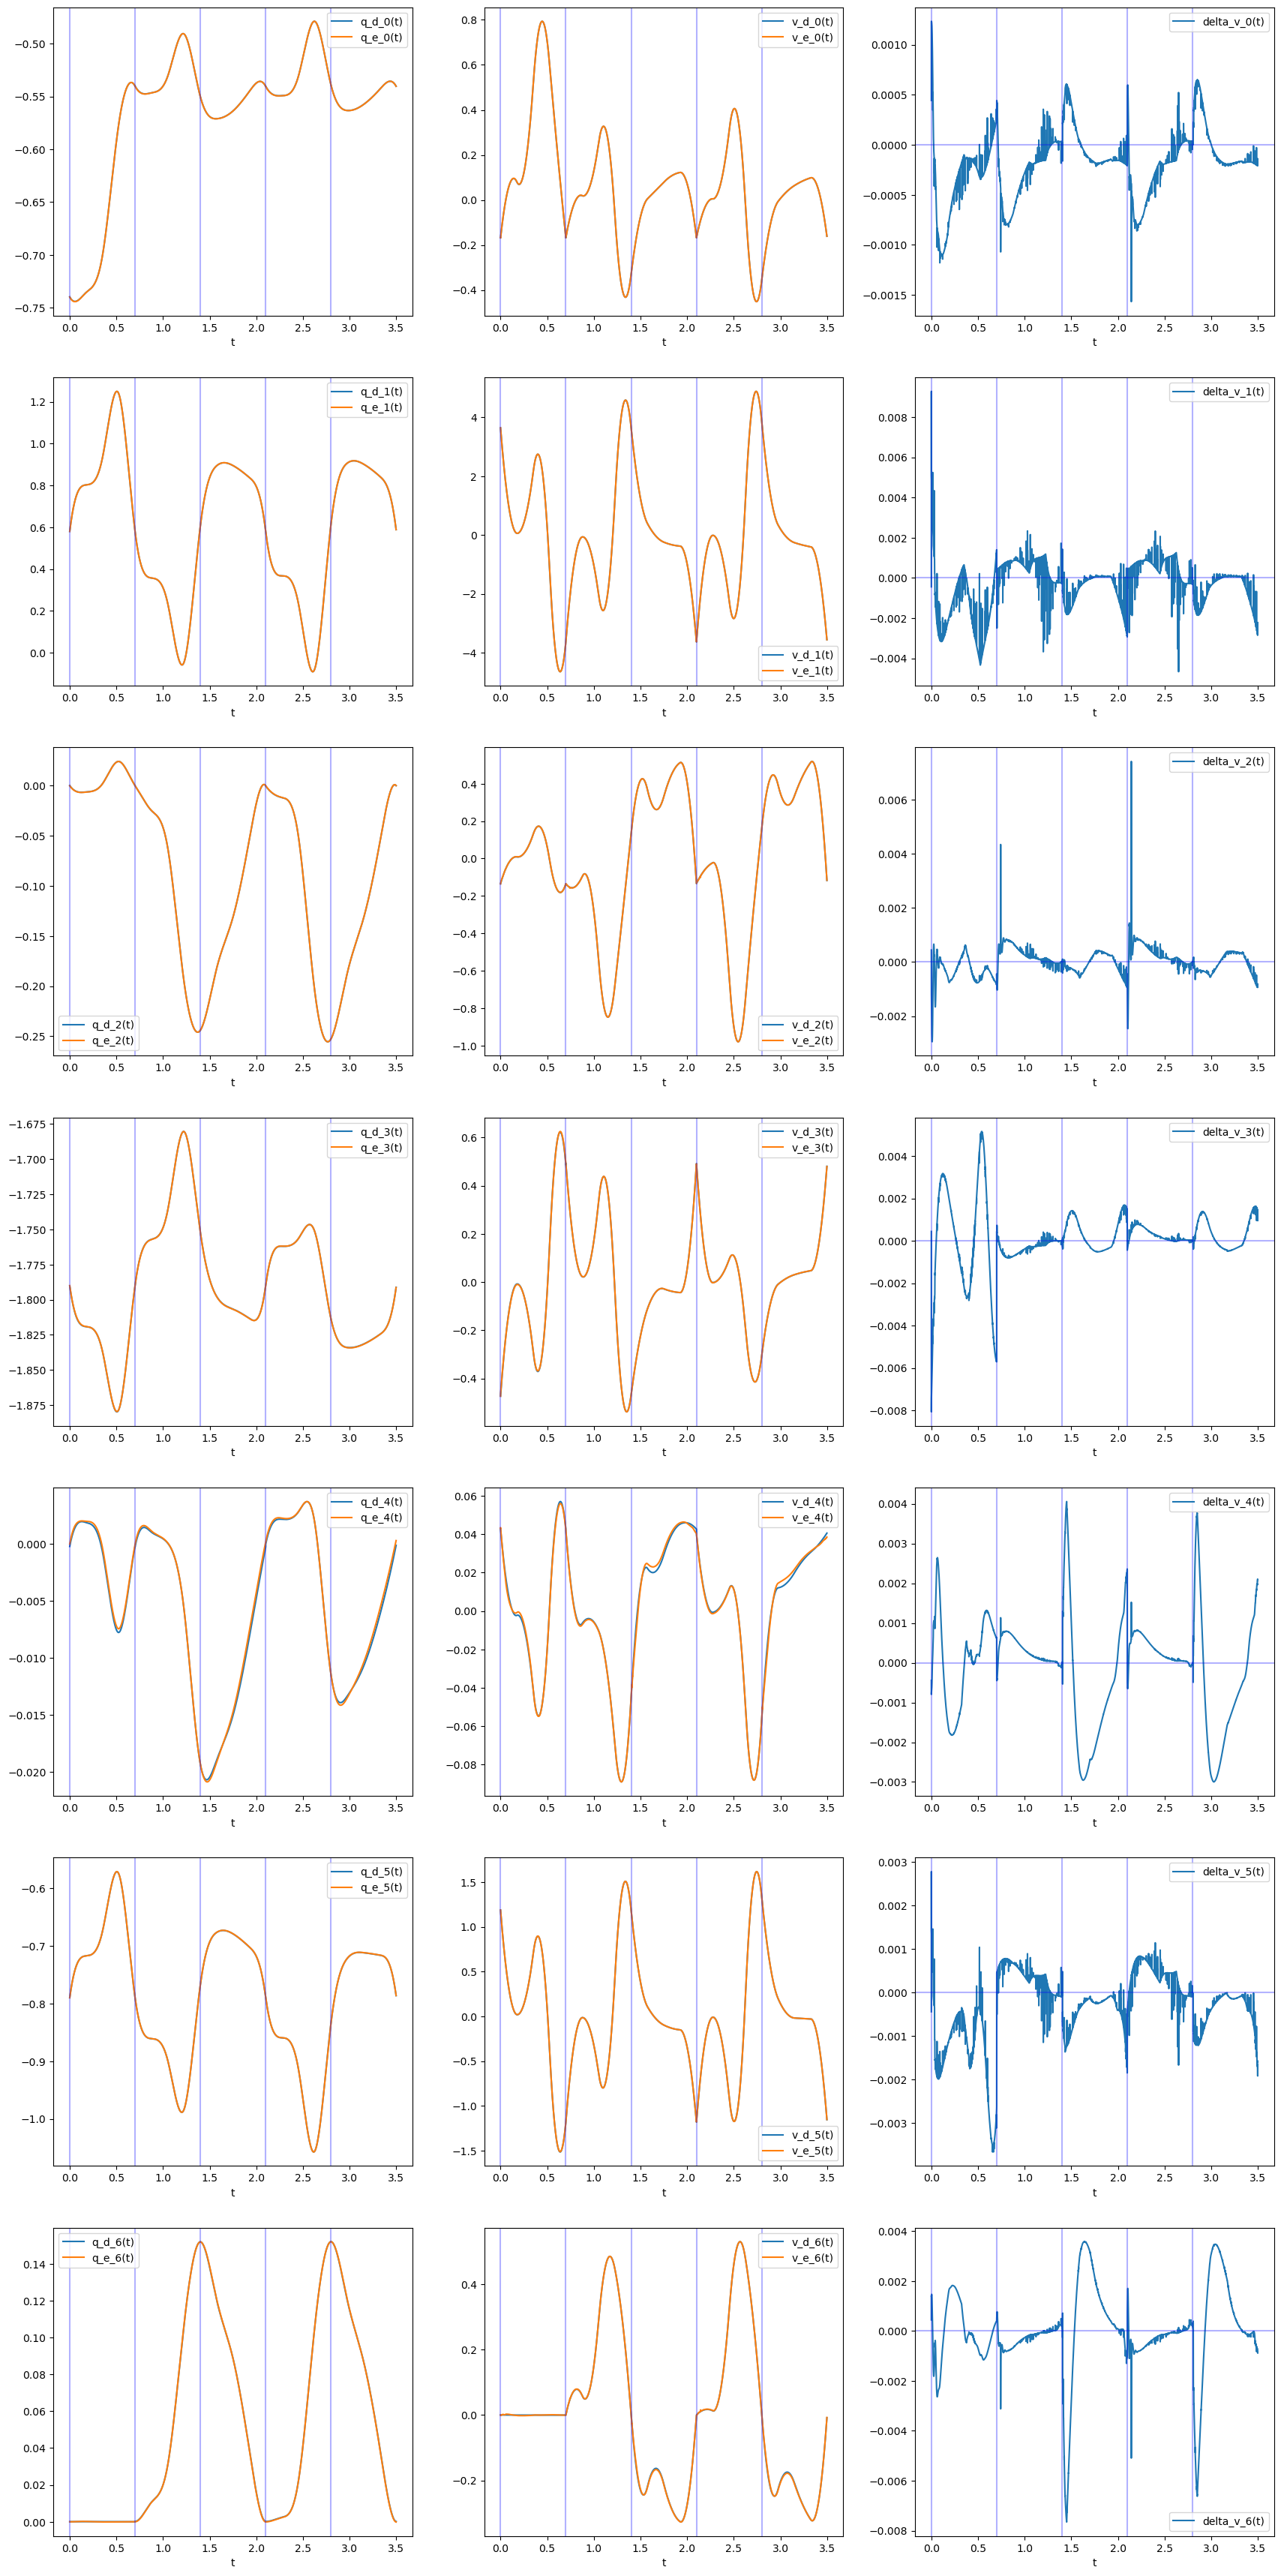

In [7]:
def clutter_clearing_demo():
    meshcat.Delete()
    builder = DiagramBuilder()

    model_directives = """
directives:
"""
    ball_file_name = "ball_small" if use_small_ball else "ball"
    for i in range(num_balls if running_as_notebook else 2):
        model_directives += f"""
- add_model:
    name: ball{i}
    file: package://one_arm_juggling/models/{ball_file_name}.sdf
"""
    # use_direct determines whether to feed the desired q, v, a into InverseDynamicsController
    # or to use the default position based iiwa controller
    if use_direct:
        station = builder.AddSystem(
                            MakeDirectManipulationStation(
                                model_directives,
                                filename="./models/one_arm_juggling_no_cams.dmd.yaml",
                                package_xmls=["./package.xml"],
                                time_step=time_step,
                                meshcat=meshcat))
    else:
        station = builder.AddSystem(
                            MyMakeManipulationStation(
                                model_directives,
                                filename="./models/one_arm_juggling.dmd.yaml",
                                package_xmls=["./package.xml"],
                                time_step=time_step))

    plant = station.GetSubsystemByName("plant")

    ball_body_indices = list(plant.GetFloatingBaseBodies())
    #ball_validator
    # ball = plant.GetBodyByName("ball")

    # ball_validator = builder.AddSystem(
    #                             BallValidator(
    #                                 ball.name(), 
    #                                 ball.index()))

    # planner
    planner = builder.AddSystem(Planner(plant, ball_body_indices))
    builder.Connect(station.GetOutputPort("body_poses"),
                    planner.GetInputPort("body_poses"))
    builder.Connect(station.GetOutputPort("body_spatial_velocities"),
                    planner.GetInputPort("body_spatial_velocities"))
    builder.Connect(station.GetOutputPort("iiwa_state_estimated"),
                    planner.GetInputPort("iiwa_state_estimated"))
    builder.Connect(station.GetOutputPort("wsg_state_measured"),
                    planner.GetInputPort("wsg_state"))
    builder.Connect(planner.GetOutputPort("wsg_position"),
                    station.GetInputPort("wsg_position"))

    if use_direct:
        builder.Connect(planner.GetOutputPort("iiwa_state_desired"),
                        station.GetInputPort("iiwa_state_desired"))
        builder.Connect(planner.GetOutputPort("iiwa_acceleration_desired"),
                        station.GetInputPort("iiwa_acceleration_desired"))
    else:       
        builder.Connect(planner.GetOutputPort("iiwa_position_command"),
                        station.GetInputPort("iiwa_position"))
    
    # builder.Connect(station.GetOutputPort("body_poses"),
    #                 ball_validator.GetInputPort("body_poses"))
    # builder.Connect(planner.GetOutputPort("traj_start_time"),
    #                 ball_validator.GetInputPort("traj_start_time"))
    # builder.Connect(station.GetOutputPort("body_spatial_velocities"),
    #                 ball_validator.GetInputPort("body_spatial_velocities"))

    meshcat_param = MeshcatVisualizerParams()
    """ kProximity for collision geometry and kIllustration for visual geometry """
    meshcat_param.role = Role.kIllustration
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, station.GetOutputPort("query_object"), meshcat, meshcat_param)

    if should_print_contact_results:
        print_contact_results = builder.AddSystem(PrintContactResults())
        builder.Connect(station.GetOutputPort("contact_results"),
                        print_contact_results.get_input_port())

    if display_plot:
        logger_state_desired = LogVectorOutput(
            planner.GetOutputPort("iiwa_state_desired"), builder
            )
        logger_state_estimated = LogVectorOutput(
            station.GetOutputPort("iiwa_state_estimated"), builder
            )
        logger_acceleration_desired = LogVectorOutput(
            planner.GetOutputPort("iiwa_acceleration_desired"), builder
            )
        # logger_acceleration_estimated = LogVectorOutput(
        #     station.GetOutputPort("iiwa_acceleration_estimated"), builder
        #     )

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_context()

    X_WThrowB_W, X_WCatchB_W = get_ball_poses_from_gripper_poses(X_WThrow, X_WCatch, p_GB_G)
    add_target_spheres(X_WThrowB_W, X_WCatchB_W, meshcat, radius=ball_radius)
    
    plant_context = plant.GetMyMutableContextFromRoot(context)

    # Ball Initialization
    plant.SetFreeBodyPose(plant_context, plant.get_body(ball_body_indices[0]), X_WCatchB_W)
    # if warm_start_velocities:
        # vel = SpatialVelocity([0,0,0],V_CatchB)
        # plant.SetFreeBodySpatialVelocity(
        #                         plant.get_body(ball_body_indices[1]),
        #                         vel, plant_context)
    if len(ball_body_indices) == 2:
        p_start, v_start = catch_pv_from_ball_pvt(X_WThrowB_W.translation(), V_ThrowB, t_duration)
        vel = SpatialVelocity([0,0,0],v_start)
        plant.SetFreeBodyPose(plant_context, plant.get_body(ball_body_indices[1]),
                                RigidTransform(RotationMatrix(), p_start))
        plant.SetFreeBodySpatialVelocity(
                                plant.get_body(ball_body_indices[1]),
                                vel, plant_context)
    if len(ball_body_indices) == 3:
        p_start, v_start = catch_pv_from_ball_pvt(X_WThrowB_W.translation(), V_ThrowB, 3*t_duration)
        vel = SpatialVelocity([0,0,0],v_start)
        plant.SetFreeBodyPose(plant_context, plant.get_body(ball_body_indices[1]),
                                RigidTransform(RotationMatrix(), p_start))
        plant.SetFreeBodySpatialVelocity(
                                plant.get_body(ball_body_indices[1]),
                                vel, plant_context)
        p_start, v_start = catch_pv_from_ball_pvt(X_WThrowB_W.translation(), V_ThrowB, t_duration)
        vel = SpatialVelocity([0,0,0],v_start)
        plant.SetFreeBodyPose(plant_context, plant.get_body(ball_body_indices[2]),
                                RigidTransform(RotationMatrix(), p_start))
        plant.SetFreeBodySpatialVelocity(
                                plant.get_body(ball_body_indices[2]),
                                vel, plant_context)
    if len(ball_body_indices) == 4:
        p_start, v_start = catch_pv_from_ball_pvt(X_WThrowB_W.translation(), V_ThrowB, 5*t_duration)
        vel = SpatialVelocity([0,0,0],v_start)
        plant.SetFreeBodyPose(plant_context, plant.get_body(ball_body_indices[1]),
                                RigidTransform(RotationMatrix(), p_start))
        plant.SetFreeBodySpatialVelocity(
                                plant.get_body(ball_body_indices[1]),
                                vel, plant_context)
        p_start, v_start = catch_pv_from_ball_pvt(X_WThrowB_W.translation(), V_ThrowB, 3*t_duration)
        vel = SpatialVelocity([0,0,0],v_start)
        plant.SetFreeBodyPose(plant_context, plant.get_body(ball_body_indices[2]),
                                RigidTransform(RotationMatrix(), p_start))
        plant.SetFreeBodySpatialVelocity(
                                plant.get_body(ball_body_indices[2]),
                                vel, plant_context)
        p_start, v_start = catch_pv_from_ball_pvt(X_WThrowB_W.translation(), V_ThrowB, t_duration)
        vel = SpatialVelocity([0,0,0],v_start)
        plant.SetFreeBodyPose(plant_context, plant.get_body(ball_body_indices[3]),
                                RigidTransform(RotationMatrix(), p_start))
        plant.SetFreeBodySpatialVelocity(
                                plant.get_body(ball_body_indices[3]),
                                vel, plant_context)
    if add_text_to_pdf:
        buffer = StringIO()
        sys.stdout = buffer
    
    print(f"--- Experiment Parameters ---")
    print(f"Controller: Feed in desired q,v,a : {use_direct}, warm start velocities: {warm_start_velocities}")
    print(f"simulation duration: {sim_duration}, time step: {time_step}")
    print(f"kin traj opt num control points: {num_control_points}, update traj after catch: {update_traj_after_catch}")
    print(f"max height: {max_height}, ball radius: {ball_radius}, WSG: open{opened} buffer({wsg_buff_open}), closed{closed} buffer({wsg_buff_close})")
    print(f"-----------------------------")
    print(f"planned ball THROW time: {t_duration}, position: {X_WThrowB_W.translation()}, velocity: {V_ThrowB}")
    print(f"planned ball CATCH time: {2 * t_duration}, position: {X_WCatchB_W.translation()}, velocity: {V_CatchB}")

    q0 = plant.GetPositions(plant_context)
    non_iiwa_q0 = q0[7:]
    gap = closed[0]
    non_iiwa_q0[0]=-gap/2
    non_iiwa_q0[1]=gap/2
    plant.SetPositions(plant_context, np.concatenate((q_Catch, non_iiwa_q0)))
    if warm_start_velocities:
        v0 = plant.GetVelocities(plant_context)
        v0[:7] = v_Catch.reshape(7,)
        plant.SetVelocities(plant_context, v0)
    simulator.AdvanceTo(0)
    meshcat.Flush()  # Wait for the large object meshes to get to meshcat.
    # Recorder
    RecordInterval(0, sim_duration, simulator, context, plant, visualizer)

    def plot_vertical_lines():
        num_lines = round(sim_duration/t_duration)
        for i in range(num_lines):
            plt.axvline(x = i*t_duration, color = 'b', alpha=0.3)
    if display_plot:
        log_state_desired = logger_state_desired.FindLog(context)
        log_state_estimated = logger_state_estimated.FindLog(context)

        f = plt.figure(figsize=(21,63))

        # print('--- Catch at t=0 ---')
        # catch_time_indices = np.where(log_state_desired.sample_times() == 0)
        # for i in range(7):
        #     print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_Catch: {v_Catch[i][:1]}")

        # print(f'--- Throw at t={t_duration}---')
        throw_time_indices = np.where(log_state_desired.sample_times() == t_duration)

        for i in range(7):
            # print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[throw_time_indices[0]]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[throw_time_indices[0]]}   v_Throw: {v_Throw[i]}")
            plt.subplot(10, 3, 7 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[i,:].transpose(),
                    log_state_estimated.sample_times(),
                    log_state_estimated.data()[i,:].transpose())
            # plt.axvline(x = t_duration, color = 'b', alpha=0.3)
            plot_vertical_lines()
            plt.legend([f'q_d_{i}(t)', f'q_e_{i}(t)'])
            plt.xlabel('t');


            plt.subplot(10, 3, 8 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[7+i,:].transpose(),
                    log_state_estimated.sample_times(),
                    log_state_estimated.data()[7+i,:].transpose())
            plot_vertical_lines()
            plt.legend([f'v_d_{i}(t)', f'v_e_{i}(t)'])
            plt.xlabel('t');

            plt.subplot(10, 3, 9 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[7+i,:].transpose() - log_state_estimated.data()[7+i,:].transpose())
            plot_vertical_lines()
            plt.axhline(y = 0, color = 'b', alpha=0.3)
            plt.legend([f'delta_v_{i}(t)'])
            plt.xlabel('t');

        # print(f'--- Catch at t={2*t_duration} ---')
        # catch_time_indices = np.where(log_state_desired.sample_times() == 2*t_duration)
        # for i in range(7):
        #     print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_Catch: {v_Catch[i][:1]}")
    
        
        if add_text_to_pdf:
            plt.subplot(4, 1, 1)
            plt.axis('off')
            print_output = buffer.getvalue()
            sys.stdout = sys.__stdout__
            plt.text(0, 0, print_output, fontsize='x-large')
        plt.savefig('plots/test.pdf')
        plt.show()

clutter_clearing_demo()

In [8]:
%tb

No traceback available to show.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68a898be-bd4e-4046-916a-6293aadf6c5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>